In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from scipy.stats import randint
import matplotlib.pyplot as plt
import torch
import gc
gc.collect()
torch.cuda.empty_cache()
from sklearn.model_selection import train_test_split

from skimage import transform
#import tensorflow as tf
#import segmentation_models as sm
#from tf.keras import layers, models

from PIL import Image

import seaborn as sns

torch.multiprocessing.set_start_method('spawn', force=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
PYDEVD_DISABLE_FILE_VALIDATION=1

In [ ]:
images_dir ='../data/images'
masks_dir = '../data/masks'
metrics_dir='../metrics'
models_dir='../models'

images = sorted(os.listdir(images_dir))
masks = sorted(os.listdir(masks_dir))
print(f"Number of images: {len(images)}")
print(f"Number of masks: {len(masks)}")

train_images, val_images, train_masks, val_masks = train_test_split(images, masks, test_size=0.2, random_state=42)


Number of images: 203
Number of masks: 203


In [9]:
train_images=np.array(train_images)
train_masks=np.array(train_masks)
val_images=np.array(val_images)
val_masks=np.array(val_masks)

In [10]:
#Generate class label map
#Building: #3C1098
#Land (unpaved area): #8429F6
#Road: #6EC1E4
#Vegetation: #FEDD3A
#Water: #E2A929
#Unlabeled: #9B9B9B
#Object
color_map = {
    (60, 16, 152):0,   # Building #Dark voilet
    (132, 41, 246):1,  # Land (unpaved area) # Bright voilet
    (110, 193, 228):2, # Road # soft blue
    (254, 221, 58):3,  # Vegetation # Bright yellow
    (226, 169, 41):4,  # Water # Bright orange
    (155, 155, 155):5  # Object # Dark Gray
}



In [11]:
Building = '#3C1098'.lstrip('#')
Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

Land = '#8429F6'.lstrip('#')
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

Road = '#6EC1E4'.lstrip('#')
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

Vegetation =  'FEDD3A'.lstrip('#')
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58

Water = 'E2A929'.lstrip('#')
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

Unlabeled = '#9B9B9B'.lstrip('#')
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155

In [12]:
def rgb_to_2D_label(label):
    """
    Suply our labale masks as input in RGB format.
    Replace pixels with specific RGB values ...
    """
    # Removed: print(f"DEBUG: Inside rgb_to_2D_label. Input label type: {type(label)}, shape: {label.shape}, dtype: {label.dtype}")

    # Ensure label is a numpy array and has 3 channels (HxWx3)
    if not isinstance(label, np.ndarray) or label.ndim != 3 or label.shape[2] != 3:
        # Removed: print(f"WARNING: Input label to rgb_to_2D_label does not have expected HxWx3 shape. Got {label.shape}")
        raise ValueError(f"Input to rgb_to_2D_label must be an HxWx3 numpy array, but got shape {label.shape}")

    height, width, _ = label.shape
    label_seg = np.zeros((height, width), dtype=np.uint8) # Initialize as a 2D array (HxW)

    # Removed: print(f"DEBUG: Type of Building: {type(Building)}, Land: {type(Land)}, Road: {type(Road)}, Vegetation: {type(Vegetation)}, Water: {type(Water)}, Unlabeled: {type(Unlabeled)}")
    # Removed: print(f"DEBUG: Building value: {Building}, type: {type(Building)}, dtype: {Building.dtype}")
    # Removed: print(f"DEBUG: Land value: {Land}, type: {type(Land)}, dtype: {Land.dtype}")
    # Removed: print(f"DEBUG: Road value: {Road}, type: {type(Road)}, dtype: {Road.dtype}")
    # Removed: print(f"DEBUG: Vegetation value: {Vegetation}, type: {type(Vegetation)}, dtype: {Vegetation.dtype}")
    # Removed: print(f"DEBUG: Water value: {Water}, type: {type(Water)}, dtype: {Water.dtype}")
    # Removed: print(f"DEBUG: Unlabeled value: {Unlabeled}, type: {type(Unlabeled)}, dtype: {Unlabeled.dtype}")

    try:
        label_seg[np.all(label == Building, axis=-1)] = 0
    except Exception as e:
        print(f"ERROR: Failed at Building comparison: {e}")
        raise

    try:
        label_seg[np.all(label == Land, axis=-1)] = 1
    except Exception as e:
        print(f"ERROR: Failed at Land comparison: {e}")
        raise

    try:
        label_seg[np.all(label == Road, axis=-1)] = 2
    except Exception as e:
        print(f"ERROR: Failed at Road comparison: {e}")
        raise

    try:
        label_seg[np.all(label == Vegetation, axis=-1)] = 3
    except Exception as e:
        print(f"ERROR: Failed at Vegetation comparison: {e}")
        raise

    try:
        label_seg[np.all(label == Water, axis=-1)] = 4
    except Exception as e:
        print(f"ERROR: Failed at Water comparison: {e}")
        raise

    try:
        label_seg[np.all(label == Unlabeled, axis=-1)] = 5
    except Exception as e:
        print(f"ERROR: Failed at Unlabeled comparison: {e}")
        raise

    return label_seg

In [13]:
!pip install tensorflow

In [14]:
import tensorflow as tf
import gc
import tensorflow_datasets as tfds

# Install tensorflow if not already installed
try:
    import tensorflow as tf
except ImportError:
    !pip install tensorflow
    import tensorflow as tf

tf.config.run_functions_eagerly(True)

# Define constants outside the function to avoid re-creation on each call
BUILDING_RGB = tf.constant([60, 16, 152], dtype=tf.uint8)
LAND_RGB = tf.constant([132, 41, 246], dtype=tf.uint8)
ROAD_RGB = tf.constant([110, 193, 228], dtype=tf.uint8)
VEGETATION_RGB = tf.constant([254, 221, 58], dtype=tf.uint8)
WATER_RGB = tf.constant([226, 169, 41], dtype=tf.uint8)
UNLABELED_RGB = tf.constant([155, 155, 155], dtype=tf.uint8)

def tf_rgb_to_2D_label(mask_rgb):
    # mask_rgb is expected to be (H, W, 3) uint8
    height, width, _ = mask_rgb.shape
    # Initialize a 2D label map with a default value (e.g., 5 for Unlabeled)
    label_map = tf.zeros((height, width), dtype=tf.int64) + 5 # Default to Unlabeled

    # Compare each pixel to the known RGB values and assign class IDs
    label_map = tf.where(tf.reduce_all(tf.equal(mask_rgb, BUILDING_RGB), axis=-1), tf.constant(0, dtype=tf.int64), label_map)
    label_map = tf.where(tf.reduce_all(tf.equal(mask_rgb, LAND_RGB), axis=-1), tf.constant(1, dtype=tf.int64), label_map)
    label_map = tf.where(tf.reduce_all(tf.equal(mask_rgb, ROAD_RGB), axis=-1), tf.constant(2, dtype=tf.int64), label_map)
    label_map = tf.where(tf.reduce_all(tf.equal(mask_rgb, VEGETATION_RGB), axis=-1), tf.constant(3, dtype=tf.int64), label_map)
    label_map = tf.where(tf.reduce_all(tf.equal(mask_rgb, WATER_RGB), axis=-1), tf.constant(4, dtype=tf.int64), label_map)
    label_map = tf.where(tf.reduce_all(tf.equal(mask_rgb, UNLABELED_RGB), axis=-1), tf.constant(5, dtype=tf.int64), label_map)

    return label_map


# convert train_images to train_paths
train_image_paths = [os.path.join(images_dir, image) for image in train_images]
train_mask_paths = [os.path.join(masks_dir, mask) for mask in train_masks]
print(f"Number of training images: {len(train_image_paths)}")
print(f"Number of training masks: {len(train_mask_paths)}")

def load_and_preprocess(image_path, mask_path):
  # Image processing
  img = tf.io.read_file(image_path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, (512, 512))
  img = tf.image.convert_image_dtype(img, tf.float32)
  # No tf.expand_dims(img, axis=0) here, batching will be handled by dataset.batch()

  # Mask processing
  mask = tf.io.read_file(mask_path)
  mask = tf.image.decode_png(mask, channels=3)
  mask = tf.image.resize(mask, (512, 512), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  mask = tf.cast(mask, tf.uint8) # Ensure mask is uint8 for RGB comparison
  mask = tf_rgb_to_2D_label(mask) # Convert RGB mask to 2D integer labels
  # No tf.expand_dims(mask, axis=0) here, batching will be handled by dataset.batch()
  mask = tf.keras.utils.to_categorical(mask, num_classes=6)

  return img, mask

# dataset initialization
dataset = tf.data.Dataset.from_tensor_slices((train_image_paths, train_mask_paths))
dataset = dataset.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.batch(8).prefetch(tf.data.AUTOTUNE)
dataset = dataset.repeat()
dataset = dataset.shuffle(buffer_size=1000)
dataset = dataset.cache()

val_image_paths=[os.path.join(images_dir, image) for image in val_images]
val_mask_paths=[os.path.join(masks_dir, mask) for mask in val_masks]
val_dataset = tf.data.Dataset.from_tensor_slices((val_image_paths, val_mask_paths))
val_dataset = val_dataset.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(8).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.repeat()
val_dataset = val_dataset.shuffle(buffer_size=1000)
val_dataset = val_dataset.cache()

tf.config.run_functions_eagerly(True)


/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:86: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


Number of training images: 162
Number of training masks: 162


/usr/local/lib/python3.12/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [11]:
import tensorflow as tf

# Install tensorflow if not already installed
try:
    import tensorflow as tf
except ImportError:
    !pip install tensorflow
    import tensorflow as tf

tf.config.run_functions_eagerly(True)

# Define constants outside the function to avoid re-creation on each call
BUILDING_RGB = tf.constant([60, 16, 152], dtype=tf.uint8)
LAND_RGB = tf.constant([132, 41, 246], dtype=tf.uint8)
ROAD_RGB = tf.constant([110, 193, 228], dtype=tf.uint8)
VEGETATION_RGB = tf.constant([254, 221, 58], dtype=tf.uint8)
WATER_RGB = tf.constant([226, 169, 41], dtype=tf.uint8)
UNLABELED_RGB = tf.constant([155, 155, 155], dtype=tf.uint8)

def tf_rgb_to_2D_label(mask_rgb):
    # mask_rgb is expected to be (H, W, 3) uint8
    height, width, _ = mask_rgb.shape
    # Initialize a 2D label map with a default value (e.g., 5 for Unlabeled)
    label_map = tf.zeros((height, width), dtype=tf.int64) + 5 # Default to Unlabeled

    # Compare each pixel to the known RGB values and assign class IDs
    label_map = tf.where(tf.reduce_all(tf.equal(mask_rgb, BUILDING_RGB), axis=-1), tf.constant(0, dtype=tf.int64), label_map)
    label_map = tf.where(tf.reduce_all(tf.equal(mask_rgb, LAND_RGB), axis=-1), tf.constant(1, dtype=tf.int64), label_map)
    label_map = tf.where(tf.reduce_all(tf.equal(mask_rgb, ROAD_RGB), axis=-1), tf.constant(2, dtype=tf.int64), label_map)
    label_map = tf.where(tf.reduce_all(tf.equal(mask_rgb, VEGETATION_RGB), axis=-1), tf.constant(3, dtype=tf.int64), label_map)
    label_map = tf.where(tf.reduce_all(tf.equal(mask_rgb, WATER_RGB), axis=-1), tf.constant(4, dtype=tf.int64), label_map)
    label_map = tf.where(tf.reduce_all(tf.equal(mask_rgb, UNLABELED_RGB), axis=-1), tf.constant(5, dtype=tf.int64), label_map)

    return label_map


# convert train_images to train_paths
train_image_paths = [os.path.join(images_dir, image) for image in train_images]
train_mask_paths = [os.path.join(masks_dir, mask) for mask in train_masks]
print(f"Number of training images: {len(train_image_paths)}")
print(f"Number of training masks: {len(train_mask_paths)}")

def load_and_preprocess(image_path, mask_path):
  # Image processing
  img = tf.io.read_file(image_path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, (512, 512))
  img = tf.image.convert_image_dtype(img, tf.float32)
  # Removed: img = tf.expand_dims(img, axis=0) # Add a channel dimension

  # Mask processing
  mask = tf.io.read_file(mask_path)
  mask = tf.image.decode_png(mask, channels=3)
  mask = tf.image.resize(mask, (512, 512), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  mask = tf.cast(mask, tf.uint8) # Ensure mask is uint8 for RGB comparison
  mask = tf_rgb_to_2D_label(mask) # Convert RGB mask to 2D integer labels
  # Removed: mask = tf.expand_dims(mask, axis=0)
  mask = tf.keras.utils.to_categorical(mask, num_classes=6)

  return img, mask

# dataset initialization (assuming 'dataset' variable was previously defined or will be defined)
dataset = tf.data.Dataset.from_tensor_slices((train_image_paths, train_mask_paths))
dataset = dataset.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.batch(4).prefetch(tf.data.AUTOTUNE)
dataset = dataset.repeat()
dataset = dataset.shuffle(buffer_size=1000)
dataset = dataset.cache()

val_image_paths=[os.path.join(images_dir, image) for image in val_images]
val_mask_paths=[os.path.join(masks_dir, mask) for mask in val_masks]
print(f"Number of validation images: {len(val_image_paths)}")
print(f"Number of validation masks: {len(val_mask_paths)}")

val_dataset = tf.data.Dataset.from_tensor_slices((val_image_paths, val_mask_paths))
val_dataset = val_dataset.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(4).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.repeat()
val_dataset = val_dataset.shuffle(buffer_size=1000)
val_dataset = val_dataset.cache()


Number of training images: 162
Number of training masks: 162
Number of validation images: 41
Number of validation masks: 41


In [12]:
INPUT_SHAPE=(512, 512, 3)
model=tf.keras.Sequential([
     tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), input_shape=INPUT_SHAPE,activation='relu', padding='same'),
     tf.keras.layers.BatchNormalization(),
     tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same'),
     tf.keras.layers.BatchNormalization(),
     tf.keras.layers.MaxPool2D(pool_size=(2,2)), # Output: 256x256
     tf.keras.layers.Dropout(0.5),

     tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'),
     tf.keras.layers.BatchNormalization(),
     tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'),
     tf.keras.layers.BatchNormalization(),
     tf.keras.layers.MaxPool2D(pool_size=(2,2)), # Output: 128x128

     tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
     tf.keras.layers.BatchNormalization(),
     tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
     tf.keras.layers.BatchNormalization(),
     tf.keras.layers.MaxPool2D(pool_size=(2,2)), # Output: 64x64
     tf.keras.layers.Dropout(0.5),

     tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
     tf.keras.layers.BatchNormalization(),
     tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
     tf.keras.layers.BatchNormalization(),
     tf.keras.layers.MaxPool2D(pool_size=(2,2)), # Output: 32x32
     tf.keras.layers.Dropout(0.5),

     tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
     tf.keras.layers.BatchNormalization(),
     tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
     tf.keras.layers.BatchNormalization(),
     tf.keras.layers.MaxPool2D(pool_size=(2,2)), # Output: 16x16
     tf.keras.layers.Dropout(0.5),

     tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),
     tf.keras.layers.BatchNormalization(),
     tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),
     tf.keras.layers.BatchNormalization(),
     tf.keras.layers.MaxPool2D(pool_size=(2,2)), # Output: 8x8
     tf.keras.layers.Dropout(0.5),

     # Decoder part (upsampling to restore original dimensions)
     tf.keras.layers.UpSampling2D(size=(2, 2)), # 16x16
     tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
     tf.keras.layers.BatchNormalization(),

     tf.keras.layers.UpSampling2D(size=(2, 2)), # 32x32
     tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
     tf.keras.layers.BatchNormalization(),

     tf.keras.layers.UpSampling2D(size=(2, 2)), # 64x64
     tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
     tf.keras.layers.BatchNormalization(),

     tf.keras.layers.UpSampling2D(size=(2, 2)), # 128x128
     tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
     tf.keras.layers.BatchNormalization(),

     tf.keras.layers.UpSampling2D(size=(2, 2)), # 256x256
     tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'),
     tf.keras.layers.BatchNormalization(),

     tf.keras.layers.UpSampling2D(size=(2, 2)), # 512x512
     tf.keras.layers.Conv2D(filters=6, kernel_size=(1, 1), activation='softmax', padding='same') # Output 6 classes per pixel
])

print(model.summary())

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 512, 512, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512, 512, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 512, 512, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512, 512, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 256, 256, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256, 256, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 256, 256, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 6,300,710 (24.04 MB)

 Trainable params: 6,295,686 (24.02 MB)

 Non-trainable params: 5,024 (19.62 KB)

None


In [13]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
model.fit(dataset, epochs=50,
                    steps_per_epoch=len(train_image_paths) // 4,
                    validation_steps=len(val_image_paths) // 4,
                    validation_data=val_dataset)
tf.keras.backend.clear_session()
_ = gc.collect()
#

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.3885 - loss: 1.7836 - val_accuracy: 0.3372 - val_loss: 43.4907
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.5423 - loss: 1.4125 - val_accuracy: 0.3845 - val_loss: 19.8930
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.5458 - loss: 1.3049 - val_accuracy: 0.5933 - val_loss: 3.2394
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.5510 - loss: 1.2374 - val_accuracy: 0.5813 - val_loss: 2.2299
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.5665 - loss: 1.3004 - val_accuracy: 0.4790 - val_loss: 2.2651
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.5934 - loss: 1.2106 - val_accuracy: 0.5001 - val_loss: 2.0839
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.6178 - loss: 1.1089 - val_accuracy: 0.5471 - val_loss: 1.3265
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.5851 - loss: 1.2025 - val_accuracy: 0.5036 - val_lo

In [15]:
model.save(os.path.join(models_dir, 'model_1.h5'))
#

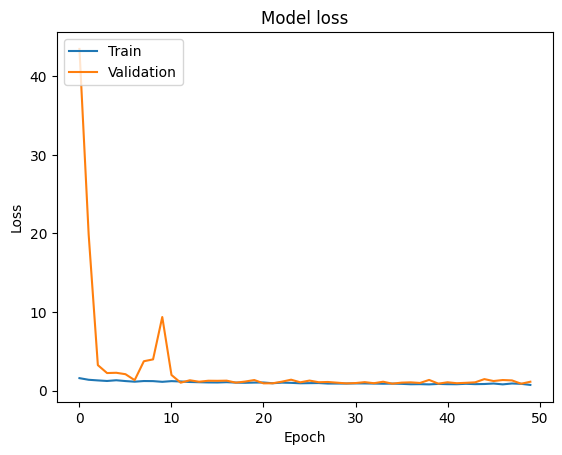

In [16]:
import matplotlib.pyplot as plt

plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
#

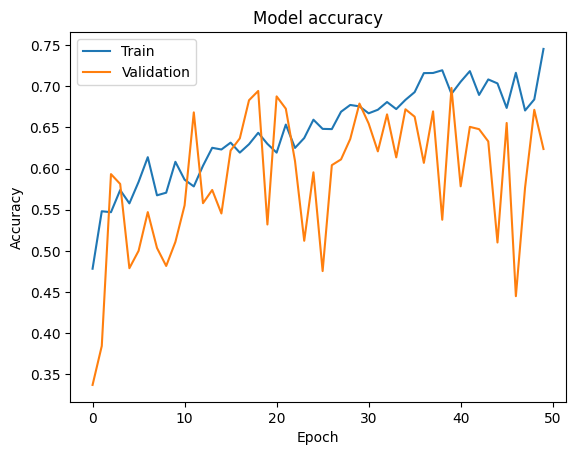

In [17]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
#


In [ ]:
preds=model.predict(val_dataset, steps=len(val_image_paths)//4)

10/10 ━━━━━━━━━━━━━━━━━━━━ 222s 728ms/step


In [2]:
import numpy as np

def apply_color_map(mask, color_map):
    # Ensure mask is a numpy array (it should be (H, W) with integer class labels)
    if not isinstance(mask, np.ndarray):
        mask = np.array(mask)

    # The mask is now (H, W), so unpack only height and width
    height, width = mask.shape
    colored_mask = np.zeros((height, width, 3), dtype=np.uint8)

    # The input color_map maps RGB_tuple -> integer_label.
    # We need to reverse this to map integer_label -> RGB_tuple for easier lookup.
    label_to_rgb = {v: k for k, v in color_map.items()}


    # Create a lookup table (palette) for colors.
    # Assuming labels are 0-indexed and contiguous up to max_label.
    # If labels are sparse, max_label + 1 needs to be adjusted or handle missing labels.
    max_label = max(label_to_rgb.keys())
    palette = np.zeros((max_label + 1, 3), dtype=np.uint8)
    for label_int, rgb_tuple in label_to_rgb.items():
        palette[label_int] = list(rgb_tuple) # Assign RGB values to palette rows

    # Use the mask values as indices into the palette to get the colored image
    # mask is (H,W), palette is (num_classes, 3)
    # The result `colored_mask` will be (H,W,3)
    colored_mask = palette[mask]

    return colored_mask

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


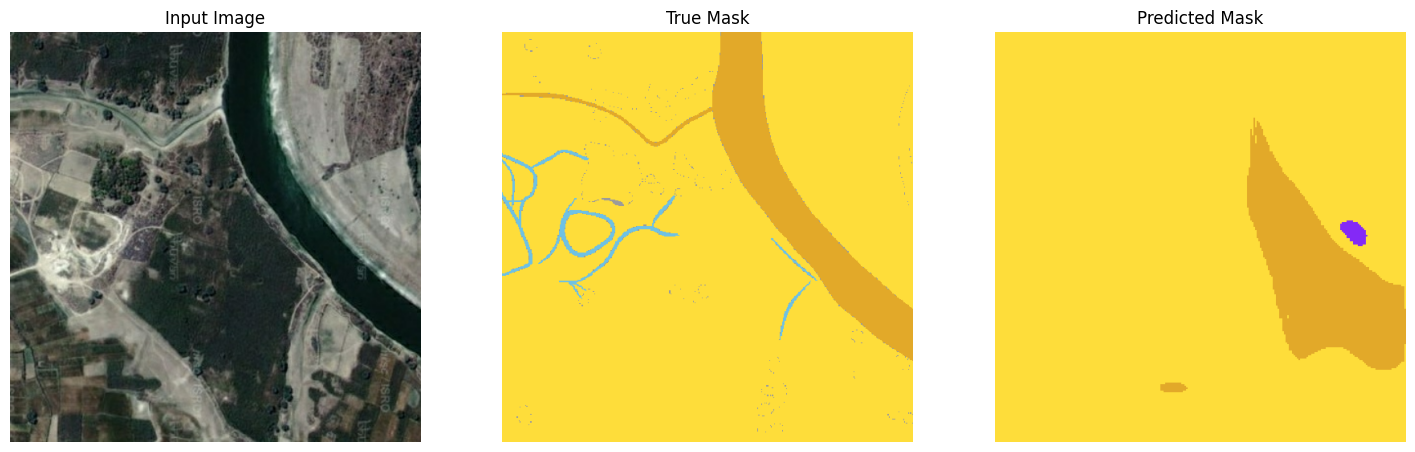

In [18]:
import random
import matplotlib.pyplot as plt

#load model
model=tf.keras.models.load_model(os.path.join(models_dir, 'model_1.h5'))

# Get one batch from the validation dataset
for image_batch, mask_batch in val_dataset.take(1):
  # Select the first image and mask from the batch
  test_img = image_batch[0]
  test_img=test_img.numpy()
  test_img=test_img.astype(np.uint8)

  test_mask_onehot = mask_batch[0]
  test_mask = tf.argmax(test_mask_onehot, axis=-1)
  test_mask=test_mask.numpy()
  test_mask=test_mask.astype(np.uint8)
  test_mask=apply_color_map(test_mask, color_map)

  test_pred=model.predict(tf.expand_dims(test_img, axis=0))
  test_pred = tf.argmax(test_pred, axis=-1)
  test_pred=test_pred[0]
  test_pred=test_pred.numpy()
  test_pred=test_pred.astype(np.uint8)
  test_pred=apply_color_map(test_pred, color_map)

  plt.figure(figsize=(18, 6)) # Increased figure width to accommodate 3 plots
  plt.subplot(1, 3, 1)
  plt.imshow(test_img)
  plt.title('Input Image')
  plt.axis('off')
  plt.subplot(1, 3, 2)
  plt.imshow(test_mask) # Use a colormap for class labels
  plt.title('True Mask')
  plt.axis('off')
  plt.subplot(1, 3, 3)
  plt.imshow(test_pred) # Use a colormap for class labels
  plt.title('Predicted Mask')
  plt.axis('off')
  plt.show()